In [211]:
import numpy as np
import matplotlib.pyplot as plt

### Ball Throw Simulation

#### True Trajectory Calculation:
The true trajectory of the ball is computed based on the initial velocity and angle of throw. The position of the ball in the X direction at time $ t $ is given by:
$$
x_{\text{true}}(t) = x_0 + v_{x0} \cdot t
$$

where $ x_0 $ is the initial position, and $ v_{x0} $ is the initial velocity in the X direction, which is calculated as $ v_{x0} = v_0 \cos(\theta) $.


Similarly, the position of the ball in the Y direction at time $ t $ is given by:

$$
y_{\text{true}}(t) = y_0 + v_{y0} \cdot t - \frac{1}{2} g t^2
$$

where $ y_0 $ is the initial position, $ v_{y0} $ is the initial velocity in the Y direction (calculated as $ v_{y0} = v_0 \sin(\theta) $), and $ g $ is the acceleration due to gravity (9.81 m/s²).

To ensure the ball does not go below the ground, we set:
$$
y_{\text{true}} = \max(y_{\text{true}}, 0)
$$

#### Observation with Noise:
To simulate realistic observations, we add Gaussian noise to the true positions. The observed positions are:
$$
\text{observed_x} = x_{\text{true}} + \mathcal{N}(0, R_{\text{std}})
$$
$$
\text{observed_y} = \max(y_{\text{true}} + \mathcal{N}(0, R_{\text{std}}), 0)
$$
where $ \mathcal{N}(0, R_{\text{std}}) $ represents Gaussian noise with mean 0 and standard deviation $ R_{\text{std}} $.


#### Dropout:
To simulate missing observations, we introduce dropout with a probability $ \text{dropout_prob} $. The dropout mask is computed as:
$$
\text{dropout_mask} = \text{rand}(num\_steps) < \text{dropout_prob}
$$
We then apply this mask to the observations:
$$
\text{observed_x}[\text{dropout_mask}] = \text{NaN}
$$
$$
\text{observed_y}[\text{dropout_mask}] = \text{NaN}
$$



In [212]:
# function to simulate the ball
def ball_throw_simulation(delta_t, total_time, initial_velocity, theta, intial_pos_x, intial_pos_y, R_std_mat, dropout_prob):
    num_steps = int(total_time / delta_t)
    t = np.linspace(0, total_time, num_steps)

    # Initial velocity in x direction
    intial_vel_x = initial_velocity * np.cos(np.radians(theta))
    # Initial velocity in y direction
    intial_vel_y = initial_velocity * np.sin(np.radians(theta))

    # calculating the true position of ball in X direction at time t
    x_true_pos = intial_pos_x + intial_vel_x * t
    # calculating the true position of ball in Y direction at time t
    y_true_pos = intial_pos_y + intial_vel_y * t - 0.5 * g * t**2

    # Implementing a Imaginary ground for better simulation. make sure that y_true_pos does not go below the ground.
    y_true_pos = np.maximum(y_true_pos, 0)

    # Adding noise to the observation of both x and y
    observed_x_pos = x_true_pos + np.random.normal(0, R_std_mat, num_steps)
    observed_y = np.maximum(y_true_pos + np.random.normal(0, R_std_mat, num_steps), 0)

    # adding drop out with an drop out propbablity
    dropout_mask = np.random.rand(num_steps) < dropout_prob
    observed_x_pos[dropout_mask] = np.nan
    observed_y[dropout_mask] = np.nan

    return t, x_true_pos, y_true_pos, observed_x_pos, observed_y

### State Transition (Prediction Step)

The state transition function predicts the next state of the system. For each ball, the position and velocity are updated based on basic kinematics equations.


#### State Transition Model:
The updated position in the X direction is given by:
$$
x_{\text{new}} = x + v_x \cdot \Delta t
$$
And the updated position in the Y direction is:
$$
y_{\text{new}} = \max(y + vy \cdot \Delta t - \frac{1}{2} g (\Delta t)^2, 0)
$$
The velocities remain constant for the X direction and decrease due to gravity for the Y direction:
$$
vx_{\text{new}} = vx
$$
$$
vy_{\text{new}} = vy - g \cdot \Delta t
$$
To account for process noise, we add Gaussian noise to the new state:
$$
\text{new_state} += \mathcal{N}(0, Q_{\text{std}})
$$

In [213]:
# function to implement the state transition
def prediction_step(state, delta_t, process_noise_std):
    # putting dposition x and y, velocity of x and y into the state
    intial_ball1_pos_x, intial_ball1_pos_y, intial_ball1_vel_x, intial_ball1_vel_y, intial_ball2_pos_x, intial_ball2_pos_y, intial_ball2_vel_x, intial_ball2_vel_y = state

    # Update the state with basic kinematics equations which mentioned in the above
    #for ball 1
    intial_ball1_pos_x_new = intial_ball1_pos_x + intial_ball1_vel_x * delta_t
    intial_ball1_pos_y_new = intial_ball1_pos_y + intial_ball1_vel_y * delta_t - 0.5 * g * delta_t**2
    intial_ball1_vel_x_new = intial_ball1_vel_x
    intial_ball1_vel_y_new = intial_ball1_vel_y - g * delta_t
    #for ball 2
    intial_ball2_pos_x_new = intial_ball2_pos_x + intial_ball2_vel_x * delta_t
    intial_ball2_pos_y_new = intial_ball2_pos_y + intial_ball2_vel_y * delta_t - 0.5 * g * delta_t**2
    intial_ball2_vel_x_new = intial_ball2_vel_x
    intial_ball2_vel_y_new = intial_ball2_vel_y - g * delta_t

    # Ensure y_new does not go below the ground for the both of the balls
    intial_ball1_pos_y_new = max(intial_ball1_pos_y_new, 0)
    intial_ball2_pos_y_new = max(intial_ball2_pos_y_new, 0)

    # adding noise to the state we have created
    new_state = np.array([intial_ball1_pos_x_new, intial_ball1_pos_y_new, intial_ball1_vel_x_new, intial_ball1_vel_y_new, intial_ball2_pos_x_new, intial_ball2_pos_y_new, intial_ball2_vel_x_new, intial_ball2_vel_y_new])
    new_state += np.random.normal(0, process_noise_std, size=new_state.shape)

    return new_state

### Likelihood Calculation (Update Step)

The likelihood function calculates the probability of an observation given the predicted state.

#### Distance Calculation:
The Euclidean distance between the predicted state and the observation for each ball is:
$$
\text{dist1} = \sqrt{(x1 - \text{obs_x1})^2 + (y1 - \text{obs_y1})^2}
$$
$$
\text{dist2} = \sqrt{(intial_ball2_pos_x - \text{obs_intial_ball2_pos_x})^2 + (y2 - \text{obs_y2})^2}
$$

#### Likelihood Calculation:
Using a Gaussian distribution, the likelihood is calculated as:
$$
\text{likelihood1} = \exp\left(-\frac{\text{dist1}^2}{2 \cdot \text{measurement_noise_std}^2}\right)
$$
$$
\text{likelihood2} = \exp\left(-\frac{\text{dist2}^2}{2 \cdot \text{measurement_noise_std}^2}\right)
$$
If observations are missing, we set the likelihood to 1 (neutral):
$$
\text{likelihood} = \text{likelihood1} \times \text{likelihood2}
$$

In [214]:

# Define the likelihood function
def likelihood_calculation(state, observation, measurement_noise_std):
    intial_ball1_pos_x, intial_ball1_pos_y, _, _, intial_ball2_pos_x, intial_ball2_pos_y, _, _ = state
    obs_intial_ball1_pos_x, obs_intial_ball1_pos_y, obs_intial_ball2_pos_x, obs_intial_ball2_pos_y = observation

    # fixing the missing values
    #for ball1
    if np.isnan(obs_intial_ball1_pos_x) or np.isnan(obs_intial_ball1_pos_y):
        likelihood1 = 1.0  # Neutral likelihood if observation is missing
    else:
        dist1 = np.sqrt((intial_ball1_pos_x - obs_intial_ball1_pos_x)**2 + (intial_ball1_pos_y - obs_intial_ball1_pos_y)**2)
        likelihood1 = np.exp(-dist1**2 / (2 * measurement_noise_std**2))
    #for ball 2
    if np.isnan(obs_intial_ball2_pos_x) or np.isnan(obs_intial_ball2_pos_y):
        likelihood2 = 1.0  # Neutral likelihood if observation is missing
    else:
        dist2 = np.sqrt((intial_ball2_pos_x - obs_intial_ball2_pos_x)**2 + (intial_ball2_pos_y - obs_intial_ball2_pos_y)**2)
        likelihood2 = np.exp(-dist2**2 / (2 * measurement_noise_std**2))

    return likelihood1 * likelihood2

### Particle Initialization

The initial particles are generated by adding Gaussian noise to the initial state:
$$
\text{particles} = \text{initial_state} + \mathcal{N}(0, \text{process_noise_std})
$$

In [215]:
# function to initialize particles
def particles_initialization(num_particles, initial_state, process_noise_std):
    particles = np.tile(initial_state, (num_particles, 1))
    particles += np.random.normal(0, process_noise_std, size=particles.shape)
    return particles

### Resampling

To focus on the most probable particles, we resample them based on their weights.

#### Resampling Particles:
First, normalize the weights:
$$
\text{weights} /= \sum(\text{weights})
$$
Then resample particles:
$$
\text{indices} = \text{random.choice}(\text{len}(\text{particles}), \text{size}=\text{len}(\text{particles}), \text{p}=\text{weights})
$$
$$
\text{particles} = \text{particles}[\text{indices}]
$$


In [216]:
# function for the resampling according to the weights
def resampling(particles, weights):
    weights = np.nan_to_num(weights, nan=1e-300)  # Replace NaN with a small number like very negligble.
    weights /= np.sum(weights)  # Normalize weights for better estimation
    indices = np.random.choice(np.arange(len(particles)), size=len(particles), p=weights)
    return particles[indices]



### State Estimation

The state is estimated by computing the weighted average of the particles:
$$
\text{estimated_state} = \text{average}(\text{particles}, \text{weights}=\text{weights}, \text{axis}=0)
$$

In [217]:
# function to estimate the
def state_estimation(particles, weights):
    return np.average(particles, weights=weights, axis=0)



### Particle Filter Algorithm

The particle filter loop iterates over each observation to predict, update, resample, and estimate the state.

#### Particle Filter Loop:
For each observation:
- **Prediction Step:** Predict the next state for each particle using the state transition model.
- **Update Step:** Calculate the likelihood of each particle given the observation and update the weights.
- **Resampling Step:** Resample particles based on the updated weights.
- **Estimation Step:** Estimate the state by computing the weighted average of the particles.


In [218]:
# function to implement the particle filter loop like mentioned above
def particle_filter(observations, num_particles, delta_t, process_noise_std, measurement_noise_std, initial_state):
    particles = particles_initialization(num_particles, initial_state, process_noise_std)
    weights = np.ones(num_particles) / num_particles

    estimated_states = []

    for observation in observations:
        # Prediction step
        particles = np.array([prediction_step(p, delta_t, process_noise_std) for p in particles])

        # Update step
        weights = np.array([likelihood_calculation(p, observation, measurement_noise_std) for p in particles])
        weights += 1e-300
        weights /= np.sum(weights)

        # Resample step
        particles = resampling(particles, weights)

        # Estimate state
        estimated_state = state_estimation(particles, weights)
        estimated_states.append(estimated_state)

    return np.array(estimated_states)

In [219]:

# Constants
g = 9.81  # Acceleration due to gravity

# Simulation parameters
delta_t = 0.06  # time step Increasing or decreasing this will have impact on the no of observation
total_time = 3  # total time of simulation
initial_velocity_1 = 20  # initial velocity of ball 1 (m/s)
theta_1 = 45  # launch angle of ball 1 (degrees)
initial_velocity_2 = 15  # initial velocity of ball 2 (m/s)
theta_2 = 60  # launch angle of ball 2 (degrees)
intial_pos_x_1, intial_pos_y_1 = 0, 0  # initial position of ball 1
intial_pos_x_2, intial_pos_y_2 = 10, 0  # initial position of ball 2
R_std_mat = 0.9  # Standard deviation of observation noise
Q_std_mat = 0.02  # Standard deviation of process noise. decreasing this will help in achiving the smooth parabola curve
dropout_prob = 0.2  # Probability of observation dropout it ranges from zero to 1. 1 will be the zero observations and 0 will be the zero dropout


In [220]:
# initialization of the state of two balls using the function defined before
initial_state = np.array([intial_pos_x_1, intial_pos_y_1, initial_velocity_1 * np.cos(np.radians(theta_1)), initial_velocity_1 * np.sin(np.radians(theta_1)),
                          intial_pos_x_2, intial_pos_y_2, initial_velocity_2 * np.cos(np.radians(theta_2)), initial_velocity_2 * np.sin(np.radians(theta_2))])

# Simulation of true trajectories and noisy observations.
t, x_true_pos_1, y_true_pos_1, obs_intial_ball1_pos_x, obs_intial_ball1_pos_y = ball_throw_simulation(delta_t, total_time, initial_velocity_1, theta_1, intial_pos_x_1, intial_pos_y_1, R_std_mat, dropout_prob)
_, x_true_pos_2, y_true_pos_2, obs_intial_ball2_pos_x, obs_intial_ball2_pos_y = ball_throw_simulation(delta_t, total_time, initial_velocity_2, theta_2, intial_pos_x_2, intial_pos_y_2, R_std_mat, dropout_prob)

# Combining observations for both balls
observations = np.vstack((obs_intial_ball1_pos_x, obs_intial_ball1_pos_y, obs_intial_ball2_pos_x, obs_intial_ball2_pos_y)).T

# running the particle fiter with define no of particles.
num_particles = 2000
estimated_states = particle_filter(observations, num_particles, delta_t, Q_std_mat, R_std_mat, initial_state)


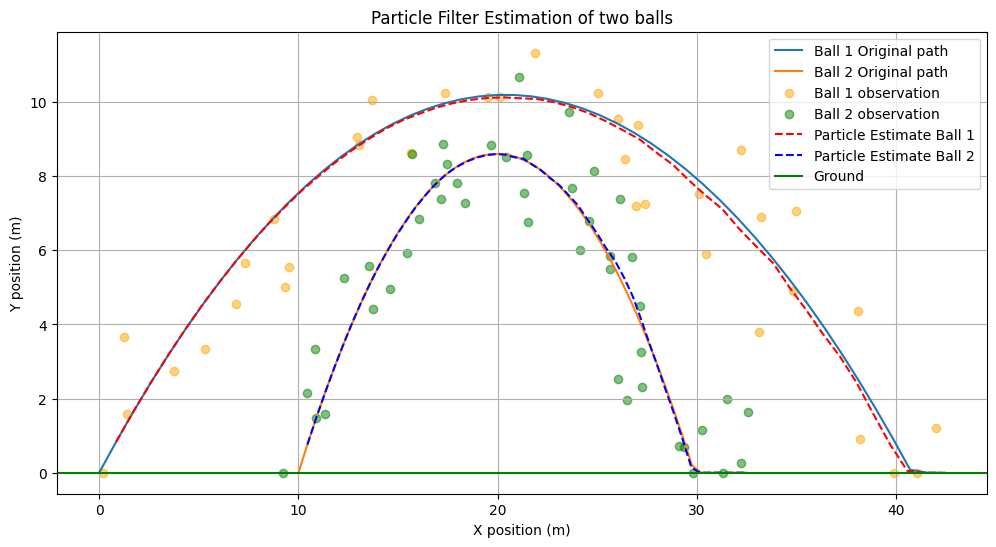

In [221]:
# Plotting the graph with observed positions and particle estimates
plt.figure(figsize=(12, 6))
plt.plot(x_true_pos_1, y_true_pos_1, label='Ball 1 Original path')
plt.plot(x_true_pos_2, y_true_pos_2, label='Ball 2 Original path')
plt.scatter(obs_intial_ball1_pos_x, obs_intial_ball1_pos_y, color='orange', label='Ball 1 observation', alpha=0.5)
plt.scatter(obs_intial_ball2_pos_x, obs_intial_ball2_pos_y, color='green', label='Ball 2 observation', alpha=0.5)
plt.plot(estimated_states[:, 0], estimated_states[:, 1], label='Particle Estimate Ball 1', linestyle='--', color='red')
plt.plot(estimated_states[:, 4], estimated_states[:, 5], label='Particle Estimate Ball 2', linestyle='--', color='blue')
plt.xlabel('X position (m)')
plt.ylabel('Y position (m)')
plt.title('Particle Filter Estimation of two balls')
plt.axhline(0, color='green', linestyle='-', label='Ground')
plt.legend()
plt.grid(True)
plt.show()

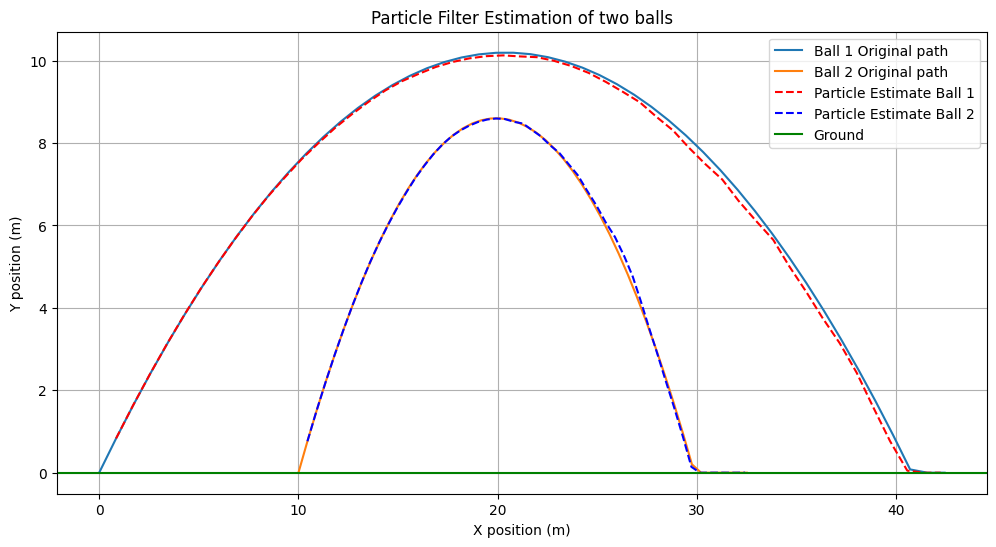

In [222]:
# Plotting graph without obsevation for better visiblity
plt.figure(figsize=(12, 6))
plt.plot(x_true_pos_1, y_true_pos_1, label='Ball 1 Original path')
plt.plot(x_true_pos_2, y_true_pos_2, label='Ball 2 Original path')
plt.plot(estimated_states[:, 0], estimated_states[:, 1], label='Particle Estimate Ball 1', linestyle='--', color='red')
plt.plot(estimated_states[:, 4], estimated_states[:, 5], label='Particle Estimate Ball 2', linestyle='--', color='blue')
plt.xlabel('X position (m)')
plt.ylabel('Y position (m)')
plt.title('Particle Filter Estimation of two balls')
plt.axhline(0, color='green', linestyle='-', label='Ground')
plt.legend()
plt.grid(True)
plt.show()